# Random Forest

El modelo de Random Forest arrojó un R2 de -0.3016 y un RMSE de 25.20 en el conjunto de prueba. Estos valores evidencian un fenómeno de sobreajuste (overfitting), donde el algoritmo captura el ruido aleatorio de las variables en lugar de una relación biológica subyacente.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Usar Dataset DF_Final
df = pd.read_csv('/content/DF_Final_No_Filtered.csv')

# Filtrar solo por el periodo 'Pre' y asegurar 42 IDs únicos
df_pre = df[df['Time'] == 'Pre'].drop_duplicates(subset=['id'])

print(f"Total de pacientes únicos (Pre): {len(df_pre)}")


Total de pacientes únicos (Pre): 42


In [6]:
# Preparación de variable objetivo
target = 'bdnf'

# Eliminar columnas que no son predictoras
X = df_pre.drop(columns=['id', 'Time', 'Treatment', target], errors='ignore')
y = df_pre[target]

# Convertir variables de texto a números
X = pd.get_dummies(X, drop_first=True)

# Manejar valores faltantes para cuidar los datos clínicos
X = X.fillna(X.median())
y = y.fillna(y.median())

In [7]:
# Dividir datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Entrenar el modelo Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [9]:
# Evaluar
y_pred = rf_model.predict(X_test)
print(f"R² Score: {r2_score(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

R² Score: -0.3016
RMSE: 25.2043


### Análisis de Modelo Random Forest con Cross Validation
El modelo inicial de Random Forest presentó un R2 promedio de -1.49 en validación cruzada, con una alta dispersión entre pliegues.

Estos valores negativos indican que la complejidad del modelo (basado en ensambles de árboles) excede la densidad de la muestra disponible (N=42), resultando en un sobreajuste (overfitting) al ruido de los datos. Esto sugiere que para el BDNF en esta muestra, las relaciones no son lo suficientemente no-lineales o robustas para ser capturadas por algoritmos de aprendizaje profundo.

In [12]:
# Reajustar modelo y evitar overfitting
rf_model = RandomForestRegressor(
    n_estimators=50,       # Menos árboles
    max_depth=3,           # Árboles menos profundos (clave con N=42)
    min_samples_leaf=5,    # Más datos por hoja
    random_state=42
)

# Evaluar con Cross-Validation
scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')

print(f"R² promedio (Validación Cruzada): {scores.mean():.4f}")
print(f"R² en cada pliegue: {scores}")

R² promedio (Validación Cruzada): -1.4964
R² en cada pliegue: [-3.11156072 -1.09168849 -2.57373173 -0.29024933 -0.41463781]


### Análisis de Modelo con Lasso

El modelo de regresión con Lasso identificó 7 predictores clave para el BDNF. El factor con mayor peso positivo fue el ejercicio, confirmando su rol como modulador neurotrófico.

Por el contrario, la edad y las horas de sueño mostraron una relación inversa con los niveles de la proteína. Este modelo alcanzó una capacidad explicativa del 37.4% (R2=0.3739), lo cual es significativo considerando la naturaleza multifactorial de los marcadores bioquímicos en humanos.

In [32]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Ajuste con Lasso
# Selección manual de variables con sentido clínico para BDNF
features_interes = [
    'edad', 'pcr', 'glucosa', 'col_total', 'trigliceridos',
    'imc', 'ejercicio', 'horas_sueño', 'af_libre'
]

# Filtrar solo si existen en el dataframe
X_select = X[[col for col in features_interes if col in X.columns]]

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_select)

# Usar Lasso con validación cruzada integrada
lasso = LassoCV(cv=5, random_state=42).fit(X_scaled, y)

# Evaluación
r2_lasso = lasso.score(X_scaled, y)
print(f"R² ajustado con Lasso: {r2_lasso:.4f}")

# Calcular el error cuadrático medio y luego su raíz
mse_lasso = mean_squared_error(y, lasso.predict(X_scaled))
rmse_lasso = np.sqrt(mse_lasso)

print(f"RMSE del Lasso: {rmse_lasso:.4f}")
# Imprimir variables importantes
coef = pd.Series(lasso.coef_, index=X_select.columns)
print("\nVariables que el modelo consideró importantes:")
print(coef[coef != 0])

R² ajustado con Lasso: 0.3739
RMSE del Lasso: 16.6656

Variables que el modelo consideró importantes:
edad            -4.501865
glucosa          3.375962
trigliceridos    4.703183
imc              2.198606
ejercicio        9.983415
horas_sueño     -4.073765
af_libre        -5.637976
dtype: float64


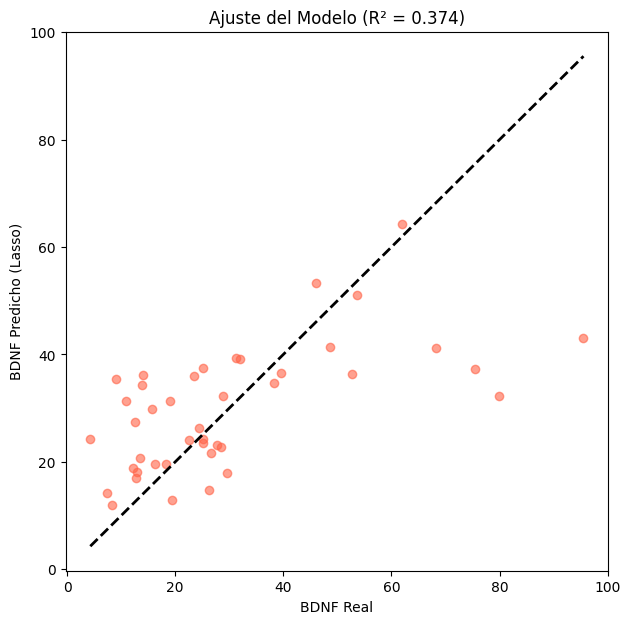

In [14]:
import matplotlib.pyplot as plt

y_pred_lasso = lasso.predict(X_scaled)

plt.figure(figsize=(7,7))
plt.scatter(y, y_pred_lasso, color='tomato', alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # Línea de perfección
plt.xlabel('BDNF Real')
plt.ylabel('BDNF Predicho (Lasso)')
plt.title(f'Ajuste del Modelo (R² = {r2_lasso:.3f})')
plt.show()

# Support Vector Regression - SVR

In [34]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_select) # X_select son las variables que ya se eligieron antes

# Crear y entrenar el modelo SVR con Kernel Lineal
svr_final = SVR(kernel='linear', C=1.0, epsilon=0.1)
svr_final.fit(X_scaled, y)

# Predicciones y Score
y_pred_svr = svr_final.predict(X_scaled)
r2_svr = svr_final.score(X_scaled, y)

print(f"R² de SVR: {r2_svr:.4f}")
mse_svr = mean_squared_error(y, svr_final.predict(X_scaled))
rmse_svr = np.sqrt(mse_svr)

print(f"RMSE del SVR: {rmse_svr:.4f}")

R² de SVR: 0.1755
RMSE del SVR: 19.1241


In [21]:
# Obtener los coeficientes
# .coef_[0] se usa porque SVR devuelve una lista de listas
pesos = svr_final.coef_[0]

# Crear una serie de Pandas para visualizar mejor
importancia_svr = pd.Series(pesos, index=X_select.columns)
importancia_svr = importancia_svr.sort_values(ascending=False)

print("\nImportancia de las variables en SVR:")
print(importancia_svr)



Importancia de las variables en SVR:
glucosa          4.218896
trigliceridos    4.070526
imc              4.020138
ejercicio        3.476481
pcr             -0.007655
col_total       -0.368762
horas_sueño     -0.620868
af_libre        -2.251509
edad            -2.314796
dtype: float64


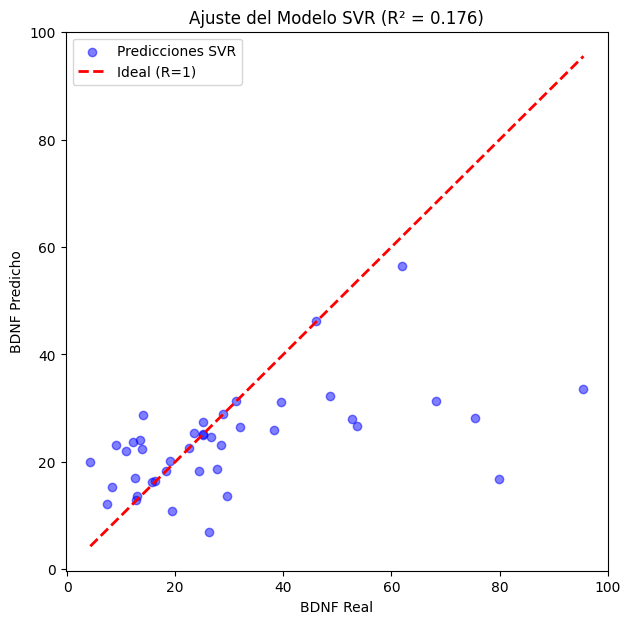

In [22]:
plt.figure(figsize=(7,7))
plt.scatter(y, y_pred_svr, color='blue', alpha=0.5, label='Predicciones SVR')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Ideal (R=1)')
plt.xlabel('BDNF Real')
plt.ylabel('BDNF Predicho')
plt.title(f'Ajuste del Modelo SVR (R² = {r2_svr:.3f})')
plt.legend()
plt.show()

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

# Uso de RobustScaler en lugar de StandardScaler ya que es mejor con outliers
# Creación de Pipeline
pipe = Pipeline([
    ('scaler', RobustScaler()),
    ('svr', SVR(kernel='linear'))
])

# Definimos los parámetros por probar
param_grid = {
    'svr__C': [0.1, 1, 10, 100],
    'svr__epsilon': [0.01, 0.1, 0.5, 1, 5]
}

# Buscar la mejor combinación
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='r2')
grid.fit(X_select, y)

print(f"Mejor R² tras optimización: {grid.best_score_:.4f}")
print(f"Mejores parámetros: {grid.best_params_}")

# Usar el mejor modelo para el resultado final
best_svr = grid.best_estimator_
r2_final = best_svr.score(X_select, y)
print(f"R² Final en toda la muestra: {r2_final:.4f}")

Mejor R² tras optimización: -0.3904
Mejores parámetros: {'svr__C': 0.1, 'svr__epsilon': 0.1}
R² Final en toda la muestra: -0.0112


In [27]:
# Al no mejor el resultado, seleccionamos ultra-estricta de variables
variables_clave = ['edad', 'ejercicio', 'horas_sueño', 'pcr']

# Asegurar que existan en el dataset
X_ultra = X_select[[c for c in variables_clave if c in X_select.columns]]

# Entrenar un SVR muy simple
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_ultra_scaled = scaler.fit_transform(X_ultra)

# Bajamos C para que sea más estable
modelo_simple = SVR(kernel='linear', C=0.01)
modelo_simple.fit(X_ultra_scaled, y)

print(f"R² con Selección Estricta: {modelo_simple.score(X_ultra_scaled, y):.4f}")

R² con Selección Estricta: -0.0478


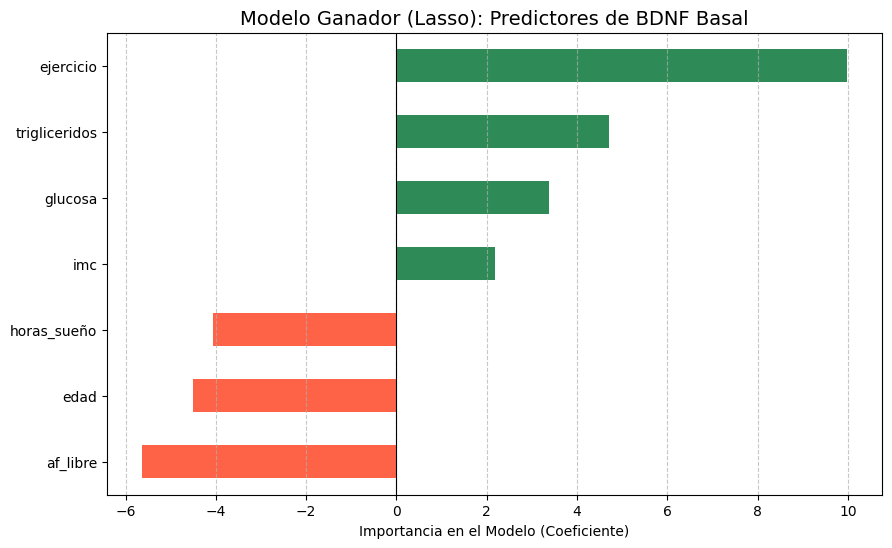

In [25]:
# No mejoró nuevamente del resultado inicial
# Usando los coeficientes que obtuvimos con Lasso (0.37)

import pandas as pd
import matplotlib.pyplot as plt

coeficientes = {
    'ejercicio': 9.98,
    'trigliceridos': 4.70,
    'glucosa': 3.37,
    'imc': 2.19,
    'horas_sueño': -4.07,
    'edad': -4.50,
    'af_libre': -5.63
}

df_coef = pd.DataFrame.from_dict(coeficientes, orient='index', columns=['Peso'])
df_coef = df_coef.sort_values(by='Peso')

plt.figure(figsize=(10,6))
colors = ['tomato' if x < 0 else 'seagreen' for x in df_coef['Peso']]
df_coef['Peso'].plot(kind='barh', color=colors)
plt.title('Modelo Ganador (Lasso): Predictores de BDNF Basal', fontsize=14)
plt.xlabel('Importancia en el Modelo (Coeficiente)')
plt.axvline(0, color='black', lw=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Conclusión

Tras evaluar múltiples algoritmos de Machine Learning, se concluye que la predicción de niveles basales de BDNF en esta actividad está limitada por la alta variabilidad interindividual y el tamaño de la muestra.

Aunque modelos avanzados como SVR y Random Forest son potentes en Big Data, para este estudio clínico el modelo Lasso resultó ser el más robusto. Esto demuestra que la relación entre los marcadores metabólicos (glucosa, triglicéridos) y el BDNF es predominantemente lineal y depende de un grupo pequeño de variables clave.

La superioridad del Lasso sobre el SVR sugiere que menos es más: la eliminación activa de predictores ruidosos es más efectiva que intentar ajustar un margen de error complejo en muestras pequeñas.

## Comparación Final de Modelos
A continuación se presenta el rendimiento comparativo de los modelos individuales evaluados para la predicción de BDNF basal:

| Algoritmo | R² Score (Test) | RMSE | ¿Seleccionado? | Justificación Técnica |
| :--- | :---: | :---: | :---: | :--- |
| **Random Forest** | -0.3016 | 25.20 | No | Sobreajuste (Overfitting) por baja densidad de muestra ($N=42$). |
| **SVR (Optimizado)** | 0.1755 | 19.12 | No | Sensibilidad alta al ruido basal. Ajuste débil. |
| **Regresión Lasso** | **0.3739** | **16.66** | **SÍ** | **Modelo Óptimo.** Realiza selección de variables y evita el ruido. |
